In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding, Flatten, LeakyReLU, Merge, BatchNormalization

from sklearn.preprocessing import StandardScaler

%matplotlib inline

Description of the data:

- instant: record index
- dteday : date
- season : season (1:springer, 2:summer, 3:fall, 4:winter)
- yr : year (0: 2011, 1:2012)
- mnth : month ( 1 to 12)
- hr : hour (0 to 23)
- holiday : weather day is holiday or not (extracted from [Web Link])
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
+ weathersit : 
  - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
  - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
  - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
  - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
- atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered

In [24]:
rides = pd.read_csv('hour.csv')
rides['time'] = pd.to_datetime(rides['dteday'])+pd.Series([pd.DateOffset(hours = a ) for a in rides.hr.tolist()])
rides.drop(['instant','yr','dteday','casual','registered', 'atemp'],1,inplace=True)
rides['t'] = rides.time.values.astype(float)
rides.head()

/Users/sachin/anaconda/lib/python3.5/site-packages/pandas/core/ops.py:533: PerformanceWarning: Adding/subtracting array of DateOffsets to Series not vectorized
  "Series not vectorized", PerformanceWarning)


,season,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,time,t
0,1,1,0,0,6,0,1,0.24,0.81,0.0,16,2011-01-01 00:00:00,1.293840e+18
1,1,1,1,0,6,0,1,0.22,0.80,0.0,40,2011-01-01 01:00:00,1.293844e+18
2,1,1,2,0,6,0,1,0.22,0.80,0.0,32,2011-01-01 02:00:00,1.293847e+18
3,1,1,3,0,6,0,1,0.24,0.75,0.0,13,2011-01-01 03:00:00,1.293851e+18
4,1,1,4,0,6,0,1,0.24,0.75,0.0,1,2011-01-01 04:00:00,1.293854e+18


In [25]:
rides.weekday.nunique()

7

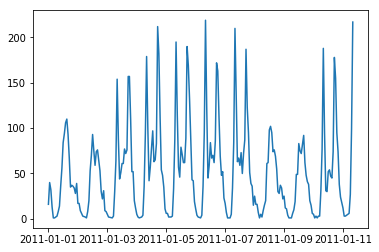

In [26]:
plt.plot(rides.time[:240],rides.cnt[:240])
plt.show()

In [27]:
quant_features = ['temp', 'hum', 'windspeed','t']
x_scaler = StandardScaler()
rides[quant_features] = x_scaler.fit_transform(rides[quant_features].values)

y_scaler = StandardScaler()
rides['cnt'] = y_scaler.fit_transform(rides['cnt'].values[:,None])

rides.head()

/Users/sachin/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


,season,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,time,t
0,1,1,0,0,6,0,1,-1.334648,0.947372,-1.553889,-0.956339,2011-01-01 00:00:00,-1.745435
1,1,1,1,0,6,0,1,-1.438516,0.895539,-1.553889,-0.824022,2011-01-01 01:00:00,-1.745236
2,1,1,2,0,6,0,1,-1.438516,0.895539,-1.553889,-0.868128,2011-01-01 02:00:00,-1.745038
3,1,1,3,0,6,0,1,-1.334648,0.636370,-1.553889,-0.972879,2011-01-01 03:00:00,-1.744840
4,1,1,4,0,6,0,1,-1.334648,0.636370,-1.553889,-1.039037,2011-01-01 04:00:00,-1.744641


In [30]:
rides['cnt'].values.shape

(17379,)

In [31]:
rides['cnt'].values[:,None].shape

(17379, 1)

In [32]:
rides['cnt'].values[None,:].shape

(1, 17379)

In [28]:
cat_features = ['season', 'hr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']

# Preprocess data so that it starts from 0
for feature in cat_features:
    if rides[feature].min() > 0:
        rides[feature] -= 1

# Embed the models
cat_models = []
for feature in cat_features:
    model_cat = Sequential()
    model_cat.add(Embedding(rides[feature].nunique(),10,input_length=1))
    model_cat.add(Flatten())
    cat_models.append(model_cat)
    
cat_model = Sequential()
cat_model.add(Merge(cat_models))

/Users/sachin/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:17: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


In [35]:
cat_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
merge_7 (Merge)              (None, 10)                0         
Total params: 550.0
Trainable params: 550.0
Non-trainable params: 0.0
_________________________________________________________________


In [33]:
feature

'weathersit'

In [34]:
rides[feature].nunique()

4

In [29]:
model_cat.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 1, 10)             40        
_________________________________________________________________
flatten_14 (Flatten)         (None, 10)                0         
Total params: 40.0
Trainable params: 40.0
Non-trainable params: 0.0
_________________________________________________________________


In [36]:
rides[quant_features].head()

,temp,hum,windspeed,t
0,-1.334648,0.947372,-1.553889,-1.745435
1,-1.438516,0.895539,-1.553889,-1.745236
2,-1.438516,0.895539,-1.553889,-1.745038
3,-1.334648,0.636370,-1.553889,-1.744840
4,-1.334648,0.636370,-1.553889,-1.744641


In [37]:
rides.head()

,season,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,time,t
0,0,0,0,0,6,0,0,-1.334648,0.947372,-1.553889,-0.956339,2011-01-01 00:00:00,-1.745435
1,0,0,1,0,6,0,0,-1.438516,0.895539,-1.553889,-0.824022,2011-01-01 01:00:00,-1.745236
2,0,0,2,0,6,0,0,-1.438516,0.895539,-1.553889,-0.868128,2011-01-01 02:00:00,-1.745038
3,0,0,3,0,6,0,0,-1.334648,0.636370,-1.553889,-0.972879,2011-01-01 03:00:00,-1.744840
4,0,0,4,0,6,0,0,-1.334648,0.636370,-1.553889,-1.039037,2011-01-01 04:00:00,-1.744641


In [7]:
quant_model = Sequential()
quant_model.add(Dense(len(quant_features),input_dim=len(quant_features)))
quant_model.add(LeakyReLU())

In [38]:
# model = Sequential()
# model.add(Merge([cat_model, quant_model, quant_model], mode='concat'))
model = quant_model
model.add(Dense(15))
model.add(LeakyReLU())
model.add(Dense(1))
model.compile(optimizer='adadelta', loss='mse')

In [39]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 4)                 20        
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 4)                 0         
_________________________________________________________________
dense_16 (Dense)             (None, 15)                75        
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 15)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 16        
Total params: 111.0
Trainable params: 111.0
Non-trainable params: 0.0
_________________________________________________________________


In [10]:
# Save the last 21 days 
test_data = rides[-21*24:]
train_data = rides[:-21*24]

In [40]:
train_x = [train_data[col].values for col in cat_features+[quant_features]]
test_x = [test_data[col].values for col in cat_features+[quant_features]]

# Train the model
model.fit(train_x, train_data['cnt'], batch_size=256)

Epoch 1/10


IndexError: indices are out-of-bounds

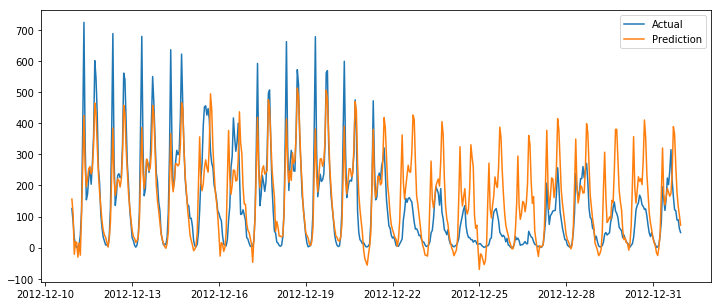

In [12]:
pred_y = model.predict(test_x, batch_size=256)
plt.figure(figsize=(12,5))
plt.plot(test_data.time, y_scaler.inverse_transform(test_data.cnt), label='Actual')
plt.plot(test_data.time, y_scaler.inverse_transform(pred_y), label='Prediction')
plt.legend()
plt.show()

In [13]:
model.evaluate(test_x, test_data['cnt'], batch_size=256)

256/504 [==============>...............] - ETA: 0s

0.31514962041188799

In [21]:
quant_model = Sequential()
quant_model.add(Dense(len(quant_features),input_dim=len(quant_features)))
model.add(BatchNormalization())
quant_model.add(LeakyReLU())

model = Sequential()
model.add(Merge([cat_model, quant_model], mode='concat'))
model.add(Dense(15))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dense(1))
model.compile(optimizer='adadelta', loss='mse')

model.fit(train_x, train_data['cnt'], batch_size=256)

/Users/sachin/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


Epoch 1/10
16875/16875 [==============================] - 0s - loss: 0.9017     
Epoch 2/10
16875/16875 [==============================] - 0s - loss: 0.5516     
Epoch 3/10
16875/16875 [==============================] - 0s - loss: 0.4284     
Epoch 4/10
16875/16875 [==============================] - 0s - loss: 0.3578     
Epoch 5/10
16875/16875 [==============================] - 0s - loss: 0.3112     
Epoch 6/10
16875/16875 [==============================] - 0s - loss: 0.2783     
Epoch 7/10
16875/16875 [==============================] - 0s - loss: 0.2499     
Epoch 8/10
16875/16875 [==============================] - 0s - loss: 0.2251     
Epoch 9/10
16875/16875 [==============================] - 0s - loss: 0.2033     
Epoch 10/10
16875/16875 [==============================] - 0s - loss: 0.1821     


In [22]:
model.evaluate(test_x, test_data['cnt'], batch_size=256)

256/504 [==============>...............] - ETA: 0s

0.22712602596434336